In [1]:
pip install tensorflow-data-validation

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 42.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.9/99.9 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.5/22.5 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.0/152.0 kB 11.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
#ls

In [2]:
#Libraries
import pandas as pd
import tensorflow_data_validation as tfdv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.metrics import mean_squared_error,r2_score

We load the data and make a quick analysis of the size of the data, this to determine if using pandas will be enough or if a more powerful tool like pyspark will be required to process and analyze the data provided.

In [3]:
data_diamonds = pd.read_csv("EDT prueba técnica/diamonds.csv")
data_diamonds.columns.values[0] = 'id'

In [4]:
data_coords = pd.read_csv("EDT prueba técnica/coords_diamonds.csv")
data_coords.columns.values[0] = 'id'

In [5]:
# dimensions of the loaded data
data_diamonds.shape

(53930, 11)

In [6]:
data_coords.shape

(53930, 3)

When you have data on the order of tens of thousands of records and 11 columns at most, using pandas will be enough.

First we try to solve the first part of the problem that says:

Show your abilities in data loading, cleaning and descriptive analysis. Some rows contain errors. Extra points: clean these rows and include them in your analysis.



Since both data sets have the same number of rows and unnamed represents an id (identifier) of each diamond, it will be enough to concat both data sets to have all the information together in a single data set.

In [7]:
full_data = pd.merge(data_diamonds, data_coords, on='id')

In [8]:
full_data.tail()

,id,carat,cut,color,clarity,depth,table,price,x,y,z,latitude,longitude
53925,53925,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50,38.5816667,-121.493333
53926,53926,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61,32.436381,-111.222442
53927,53927,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56,40.2413889,-75.284167
53928,53928,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74,38.8222222,-122.721944
53929,53929,0.75,Ideal,D,SI2,NaN,55.0,2757,NaN,NaN,3.64,31.3111111,-92.445000


To start we will perform an initial data profiling to see what types of data we have.

Regarding the previous set of data, since we are asked as a problem to estimate how much the stolen diamonds are worth, the variable that can be used as a label to denote the value of each diamond will be the variable **price**, but to determine if that will be the best option, it is necessary to do data profiling.

In [9]:
stats_diamonds = tfdv.generate_statistics_from_dataframe(full_data)

In [10]:
tfdv.visualize_statistics(stats_diamonds)


From the previous data profiling, we noticed that the categorical variables do not seem to be good candidates to use as predictor variables, since they have unique values close to 30, so when converting them to dummy variables to be processed in a model predictive, they would be transformed into 30 more variables, making the implementation much more complex as well as the computational cost, so their possible use would only be evaluated if an acceptable performance was not achieved with the numerical variables, for example below 70 percent.

# Data setting

In [11]:
full_data.dtypes

id              int64
carat         float64
cut            object
color          object
clarity        object
depth         float64
table         float64
price           int64
x             float64
y             float64
z             float64
latitude       object
longitude     float64
dtype: object

It is necessary to convert the latitude variable to a float64 type variable, since Python identifies it as an object type.

In [12]:
full_data['latitude'] = pd.to_numeric(full_data['latitude'], errors='coerce')

In [13]:
full_data.dtypes

id              int64
carat         float64
cut            object
color          object
clarity        object
depth         float64
table         float64
price           int64
x             float64
y             float64
z             float64
latitude      float64
longitude     float64
dtype: object

Having completed this first data profiling, we realize that price could be used as a response variable. Regarding the other variables, as hypotheses, all of them could be useful to predict the price variable, but we need to do more statistical analysis to complement the analysis provided by tfdv. To do this, we will do a correlation analysis between the variables.

In [14]:
correlacion_pearson = full_data.corr(method='pearson')

<ipython-input-14-34aadb28d36b>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlacion_pearson = full_data.corr(method='pearson')


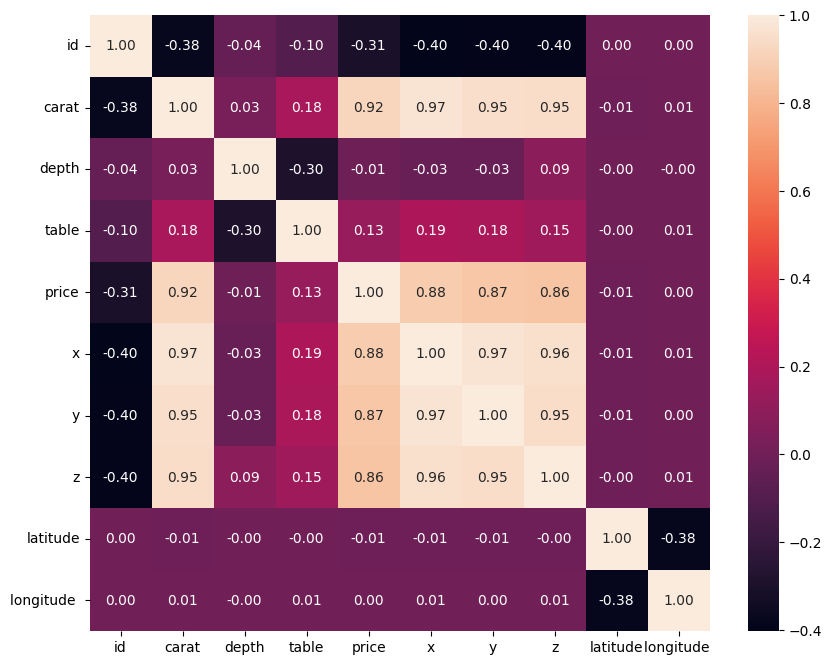

In [15]:
plt.figure(figsize=(10,8))
sns.heatmap(correlacion_pearson, annot=True, fmt=".2f")
plt.show()

Analyzing the type of correlation that the variable **price** has with the others, we see that it has a high linear correlation with the variables **carat**, **x**, **y**, **z**, on the other hand it does not seem to have a linear relationship with the variable **depth** and **longitude** and **latitude**. Furthermore, since **price** is more linearly correlated with the variable **x** than with **y** or **z** and since **x** **y** and **z** are in turn highly correlated, we can use the variables **carat** and **x** to make our predictions.

## Model implementation

### Train model

We choose the response variable and the predictor variables from our data set:

In [16]:
X = full_data[['carat', 'z']]  # predictor variables
y = full_data['price']  # target variable/response variable



Conveniently, z was chosen because it does not have missing values and given the correlation that exists with "x" and "y" it is pertinent to use "z" instead of the other variables that do have missing values; For practicality and as it will be the first model implemented, it is better to choose "z".

We split the data set into training and test sets with a standard 80-20 split.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [18]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)


LinearRegression()


Predictions are made and the mean square error is evaluated:

In [19]:
y_pred = model_lr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Square Error: {mse}")

Mean Square Error: 2260251.9497036333


and r2 metric:

In [20]:
r2 = r2_score(y_test, y_pred)
print(f"Model performance with r2: {r2}")

Model performance with r2: 0.8604305298215819



This means that the model can correctly explain 96 percent of the data.

## Using Cross Validation:



Cross-validation involves dividing the data set into multiple segments and training and testing the model on these segments iteratively. This will help us get a more accurate estimate of the model's performance on unseen data, compared to simply training and testing with a single test data set.

In [21]:
r2_scores = cross_val_score(model_lr, X, y, cv=5, scoring='r2')

In [22]:
average_r2_score = np.mean(r2_scores)
print(f"Mean R^2: {average_r2_score}")


Mean R^2: -1.083242973943078


## Improve model performance

To try to improve the performance of the model, we will resort to normalizing the two predictor variables that we are using:

In [23]:
min_max_scaler = MinMaxScaler()
full_data[['price', 'z']] = min_max_scaler.fit_transform(full_data[['price', 'z']])

We confirm that they have been correctly normalized

In [24]:
stats_diamonds_mod = tfdv.generate_statistics_from_dataframe(full_data)

In [25]:
tfdv.visualize_statistics(stats_diamonds_mod)


We see that they have indeed been normalized, so now we can try training the model again:

In [26]:
X = full_data[['price','z']]  # variables predictoras # X = full_data[['price', 'z']]
y = full_data['carat']  # variable objetivo/ variable de respuesta

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

r2_scores_mod = cross_val_score(model_lr, X, y, cv=5, scoring='r2')

average_r2_score_mod = np.mean(r2_scores_mod)
print(f"Mean R^2 (linear regression): {average_r2_score_mod}")


Mean R^2 (linear regression): 0.7033492145229289


## Ridge regression

Now, we let to try train with another model.

In [27]:
# Ridge regression model
model_ridge = Ridge(alpha=1.0)


In [28]:
# Apply cross validation
r2_scores = cross_val_score(model_ridge, X, y, cv=5, scoring='r2')


In [29]:
# Calculate mean R^2
average_r2_score = np.mean(r2_scores)
print(f"Mean R^2 (ridge regression): {average_r2_score}")


Mean R^2 (ridge regression): 0.7467314194982008
